In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import glob
import itertools
import math

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool

In [2]:
def load_data(data_dir, region):
    region = region.replace(':', '-')
    up_pval_file   = data_dir + region + '-up_log-pval.mat'
    down_pval_file = data_dir + region + '-down_log-pval.mat'

    fc_files = glob.glob(data_dir + region + '*-foldchange.mat')
    if len(fc_files) == 1:
        fc_file = fc_files[0]
    else:
        print("In the following region:" + region)
        print('FC file is not unique.')
        sys.exit()
    
    pval_list_up = io.loadmat(up_pval_file)['matrix'][0]
    pval_list_down = io.loadmat(down_pval_file)['matrix'][0]
    fc = io.loadmat(fc_file)['matrix'][0]
    
    num_sgrna_cell = int(fc_file.split('/')[-1].split('-')[2])
    return pval_list_up, pval_list_down, fc, num_sgrna_cell

In [3]:
#Manhatthan Plot for up- and down-regulated genes separately
#get the FDR by using Benjamin-Hochberg methods
def pval_calculator(fc, annot_df, pval_list_up, pval_list_down):
    up_idx        = np.where(np.array(fc) > 1)[0]
    down_idx      = np.where(np.array(fc) < 1)[0]
    plot_down_idx = np.intersect1d(down_idx, annot_df.idx)
    plot_up_idx   = np.intersect1d(up_idx, annot_df.idx)

    #preprocess the pvals for plotting
    pval_list_up[np.argwhere(pval_list_up == 0)] = 1
    pval_list_up[np.isinf(pval_list_up)] = 0

    pval_list_down[np.argwhere(pval_list_down == 0)] = 1
    pval_list_down[np.isinf(pval_list_down)] = 0

    #calculate the p_value for plotting
    combined_p_val = [0] * (len(fc))

    for i in up_idx:
        if (-1*pval_list_up[i] - unordered_up_percent_list[i] > 0):
            combined_p_val[i] = (-1*pval_list_up[i] - unordered_up_percent_list[i]) / np.log(10)
        else:
            combined_p_val[i] = 0

    for i in down_idx:

        if (pval_list_down[i] + unordered_down_percent_list[i] < 0):
            combined_p_val[i] = (pval_list_down[i] + unordered_down_percent_list[i]) / np.log(10)
        else:
            combined_p_val[i] = 0
        
    combined_p_val=np.array(combined_p_val)
    return combined_p_val

In [4]:
def get_distance(region, gene_pos, annot_df):
    length_list = [
        0, 248956422,491149951,689445510,879660065,1061198324,               
        1232004303,1391350276,1536488912,1674883629,1808681051,
        1943767673,2077042982,2191407310,2298451028,2400442217,
        2490780562,2574038003,2654411288,2713028904,2777473071,
        2824183054,2875001522,3031029399
    ]
    
    chr_order = [
        'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 
        'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
        'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX'
    ]
    
    enh_chrom, left, right = re.split('[:|-]', region)
    dist =  int(gene_pos) - int(left) - length_list[chr_order.index(enh_chrom)]
    
    return np.absolute(dist)

In [5]:
#load the annotation information
working_dir = '../Data/'

length_list = [0, 248956422,491149951,689445510,879660065,1061198324,
               1232004303,1391350276,1536488912,1674883629,1808681051,
               1943767673,2077042982,2191407310,2298451028,2400442217,
               2490780562,2574038003,2654411288,2713028904,2777473071,
               2824183054,2875001522,3031029399]
    
chr_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 
             'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
             'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']

annot_df = pd.read_csv(working_dir + 'Annotations/plot_annotation.txt',
                       header = None, 
                       sep='\t',
                       names = ["idx", "gene_names", "chromosome", "pos", "strand", "color_idx", "chr_idx"])

In [6]:
#load the background p-val for multiple hypothesis test
#percent_dir = '/project/GCRB/Hon_lab/s160875/03.analysis/Mosaic-seq/CROP-DE-analysis_10X-66K_no_downsampling-CPM.hg38/\
#rand_sgrna/hypergeo_test_metacell_rand-sgrna/'

percent_dir = working_dir + 'Gene_cutoff/'

up_percent_file = percent_dir + 'Perct_99.9_combined_cutoff.up_genes.mat'
unordered_up_percent_list = np.asarray(io.loadmat(up_percent_file)['matrix']).squeeze()
down_percent_file = percent_dir + 'Perct_99.9_combined_cutoff.down_genes.mat'
unordered_down_percent_list = np.asarray(io.loadmat(down_percent_file)['matrix']).squeeze()

In [7]:
#load local hits df
local_gene_df = pd.read_pickle(working_dir + '/Hits_calling/local_hits_99.9.pkl')

In [8]:
#load data
data_dir = working_dir + 'Hypergeometric_pvals/'

global_hits_df = pd.DataFrame(columns=[
    'idx', 'gene_names', 'chromosome', 
    'pos', 'strand', 'chr_idx', 'region', 'log2fc',
    '-log10padj',
    ])
    
for region in np.unique(local_gene_df.region.values):
    pval_list_up, pval_list_down, fc, num_sgrna_cell = load_data(data_dir, region)
    enh_chrom, left, right = re.split(r'[:-]+', region)
    combined_p_val = pval_calculator(fc, annot_df, pval_list_up, pval_list_down)
    
    #get the outlier
    raw_outliers = []
    counter = 0
    for i,e in enumerate(combined_p_val):
        if (e < -1.9 or e > 2.8):
            raw_outliers.append(counter)
        counter += 1
    outliers = np.intersect1d(raw_outliers, annot_df.idx)

    #if there is any DE gene, output the csv file containing all the significant genes
    if any(outliers):
        for i in outliers:
            chrom, left, right = re.split('[:|-]', region)
            
            hits_gene_series = annot_df.loc[annot_df.idx == i].iloc[0,:]
            dist = get_distance(region, hits_gene_series['pos'], annot_df)  
            
            if (chrom == hits_gene_series.chromosome) & (dist < 2e6):
                continue

            hits_gene_series['distance'] = dist
            hits_gene_series['log2fc'] = np.log2(fc[i])
            if fc[i] > 1:
                hits_gene_series['-log10padj'] = combined_p_val[i]
            elif fc[i] < 1:
                hits_gene_series['-log10padj'] = -1*combined_p_val[i]
                
            hits_gene_series['region'] = region
            global_hits_df = global_hits_df.append(hits_gene_series)

In [9]:
np.unique(global_hits_df.region.values)

array(['chr10:61765677-61766077', 'chr10:72320697-72321097',
       'chr11:33881869-33882269', 'chr11:33941648-33942048',
       'chr11:33944788-33945188', 'chr11:65497344-65497744',
       'chr12:54304291-54304691', 'chr16:88979007-88979407',
       'chr16:88992367-88992767', 'chr17:42319937-42320337',
       'chr18:46061469-46061869', 'chr18:57659563-57659963',
       'chr18:9825498-9825898', 'chr18:9877238-9877638',
       'chr19:28544588-28544988', 'chr1:11671358-11671758',
       'chr1:160540165-160540565', 'chr1:167627738-167628138',
       'chr1:182299980-182300380', 'chr1:25933464-25933864',
       'chr1:26286984-26287384', 'chr1:31928734-31929134',
       'chr20:47331291-47331691', 'chr5:54313325-54313725',
       'chr6:135306757-135307157', 'chr6:135321297-135321697',
       'chr6:135323137-135323537', 'chr6:135325637-135326037',
       'chr6:36888999-36889399', 'chr6:37183239-37183639',
       'chr7:149719004-149719404', 'chr7:150320886-150321286',
       'chr7:150960307-150

### Generate an order for the regions

In [10]:
region_global = pd.DataFrame(columns=['chr_idx', 'left', 'region'])
for r in np.unique(global_hits_df.region.values):
    region_global_series = pd.Series()
    chr_name, left, right = re.split('[:|-]', r)
    if chr_name[3:] == 'X':
        region_global_series['chr_idx'] = 24
    else:
        region_global_series['chr_idx'] = int(chr_name[3:])
    region_global_series['left'] = left
    region_global_series['region'] = r
    
    region_global = region_global.append(region_global_series, ignore_index=True)

In [11]:
sorted_regions = region_global.sort_values(by=['chr_idx', 'left']).region.values

In [12]:
sorted_regions

array(['chr1:11671358-11671758', 'chr1:160540165-160540565',
       'chr1:167627738-167628138', 'chr1:182299980-182300380',
       'chr1:25933464-25933864', 'chr1:26286984-26287384',
       'chr1:31928734-31929134', 'chr5:54313325-54313725',
       'chr6:135306757-135307157', 'chr6:135321297-135321697',
       'chr6:135323137-135323537', 'chr6:135325637-135326037',
       'chr6:36888999-36889399', 'chr6:37183239-37183639',
       'chr7:149719004-149719404', 'chr7:150320886-150321286',
       'chr7:150960307-150960707', 'chr8:128044869-128045269',
       'chr10:61765677-61766077', 'chr10:72320697-72321097',
       'chr11:33881869-33882269', 'chr11:33941648-33942048',
       'chr11:33944788-33945188', 'chr11:65497344-65497744',
       'chr12:54304291-54304691', 'chr16:88979007-88979407',
       'chr16:88992367-88992767', 'chr17:42319937-42320337',
       'chr18:46061469-46061869', 'chr18:57659563-57659963',
       'chr18:9825498-9825898', 'chr18:9877238-9877638',
       'chr19:28544588-2

In [13]:
global_hits_df.loc[global_hits_df.region == 'chr8:128044869-128045269']

,idx,gene_names,chromosome,pos,strand,chr_idx,region,log2fc,-log10padj,color_idx,distance
13780,13780,RPL34,chr4,798066076,+,3,chr8:128044869-128045269,-0.018664,2.322105,1.0,7.213291e+08
30588,30572,HBG2,chr11,1814186656,-,10,chr8:128044869-128045269,0.288974,7.889784,0.0,2.947915e+08
31691,31691,MRPL16,chr11,1868491923,-,10,chr8:128044869-128045269,0.228296,2.960408,0.0,3.490968e+08
49038,49038,TIMM13,chr19,2656839182,-,18,chr8:128044869-128045269,-0.036922,2.411508,0.0,1.137444e+09
49311,49311,TIMM44,chr19,2662355208,-,18,chr8:128044869-128045269,-0.289515,2.019682,0.0,1.142960e+09
49952,49952,ZNF101,chr19,2674080084,+,18,chr8:128044869-128045269,-0.974853,2.669499,0.0,1.154685e+09


In [14]:
global_hits_df.loc[global_hits_df.region == 'chr6:135323137-135323537'].shape

(191, 11)

In [15]:
overlap_num_array = []
overlap_ratio_array = []
for i in np.arange(len(sorted_regions)):
    current_region = sorted_regions[i]
    current_hits = global_hits_df.loc[global_hits_df.region == current_region].gene_names.values
    for ii in np.arange(len(sorted_regions)):
        test_region = sorted_regions[ii]
        test_hits = global_hits_df.loc[global_hits_df.region == test_region].gene_names.values
        overlap_num = len(set(current_hits).intersection(set(test_hits)))
        overlap_ratio = overlap_num / len(current_hits)
        if current_region == 'chr6:135323137-135323537':
            
            print(sorted_regions[i], end='\t')
            print(len(current_hits), end = '\t')
            print(sorted_regions[ii], end='\t')
            print(len(test_hits), end = '\t')
            print(overlap_num)
        overlap_num_array.append(overlap_num)
        overlap_ratio_array.append(overlap_ratio)

chr6:135323137-135323537	191	chr1:11671358-11671758	1	0
chr6:135323137-135323537	191	chr1:160540165-160540565	1	0
chr6:135323137-135323537	191	chr1:167627738-167628138	1	1
chr6:135323137-135323537	191	chr1:182299980-182300380	2	0
chr6:135323137-135323537	191	chr1:25933464-25933864	2	0
chr6:135323137-135323537	191	chr1:26286984-26287384	1	0
chr6:135323137-135323537	191	chr1:31928734-31929134	1	1
chr6:135323137-135323537	191	chr5:54313325-54313725	1	0
chr6:135323137-135323537	191	chr6:135306757-135307157	14	12
chr6:135323137-135323537	191	chr6:135321297-135321697	21	16
chr6:135323137-135323537	191	chr6:135323137-135323537	191	191
chr6:135323137-135323537	191	chr6:135325637-135326037	4	4
chr6:135323137-135323537	191	chr6:36888999-36889399	1	0
chr6:135323137-135323537	191	chr6:37183239-37183639	1	0
chr6:135323137-135323537	191	chr7:149719004-149719404	1	0
chr6:135323137-135323537	191	chr7:150320886-150321286	2	0
chr6:135323137-135323537	191	chr7:150960307-150960707	1	0
chr6:135323137-13532

In [19]:
np.sum(np.array(overlap_num_array).reshape(35,35) > 0)

143

In [22]:
(143-35) / 2

54.0

In [20]:
num = 34
summary = 0
while num > 0:
    summary += num
    num -= 1

In [21]:
summary

595

In [26]:
from scipy.stats import hypergeom
hypergeom.sf(54, 133652, 68, 595)

1.0716114755620055e-117

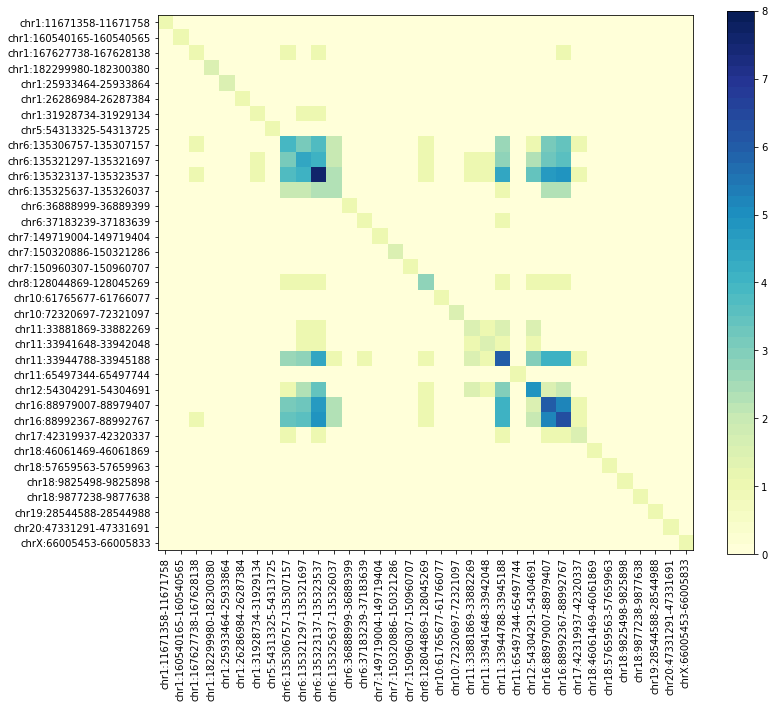

In [113]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as CM
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

logt_matrix = np.log2((np.array(overlap_num_array) + 1)).reshape(35,35)
fig, ax = plt.subplots(figsize=(12,10))
cmap = CM.get_cmap('YlGnBu', 50)
count_heatmap = ax.imshow(logt_matrix, cmap=cmap, vmin=0, vmax=8)

ax.set_xticks(np.arange(len(sorted_regions)))
ax.set_yticks(np.arange(len(sorted_regions)))
# ... and label them with the respective list entries
ax.set_xticklabels(sorted_regions, rotation=90)
ax.set_yticklabels(sorted_regions)

cbar = fig.colorbar(count_heatmap, ax=ax)

plt.savefig('Overlapped_global_hits.pdf')